In [1]:
from ioMicro import *
import numpy as np
import os
import dask.array as da
def get_tzxy_plus_minus(obj_Xh_plus,obj_Xh_minus,obj_ref_Xh_plus,obj_ref_Xh_minus,resc=5,th=0):
    tzxyf,tzxy_plus,tzxy_minus,N_plus,N_minus = np.array([0,0,0]),np.array([0,0,0]),np.array([0,0,0]),0,0
    if (len(obj_Xh_plus)>0) and (len(obj_ref_Xh_plus)>0):
        X = obj_Xh_plus[obj_Xh_plus[:,-1]>th][:,:3]
        X_ref = obj_ref_Xh_plus[obj_ref_Xh_plus[:,-1]>th][:,:3]#obj_ref_Xh_plus[:,:3]
        tzxy_plus,N_plus = get_best_translation_points(X,X_ref,resc=resc,return_counts=True)
    if (len(obj_Xh_minus)>0) and (len(obj_ref_Xh_minus)>0):
        X = obj_Xh_minus[obj_Xh_minus[:,-1]>th][:,:3]
        X_ref = obj_ref_Xh_minus[obj_ref_Xh_minus[:,-1]>th][:,:3]#obj_ref_Xh_plus[:,:3]
        tzxy_minus,N_minus = get_best_translation_points(X,X_ref,resc=resc,return_counts=True)
    if np.max(np.abs(tzxy_minus-tzxy_plus))<=2:
        tzxyf = -(tzxy_plus*N_plus+tzxy_minus*N_minus)/(N_plus+N_minus)
    else:
        tzxyf = -[tzxy_plus,tzxy_minus][np.argmax([N_plus,N_minus])]
    return [tzxyf,tzxy_plus,tzxy_minus,N_plus,N_minus]    
def get_best_translation_pointsT(fov,htag,htagref,save_folder,save_folder_ref,set_='',resc=5,th=0):
    fl_feats = rf'{save_folder}\{fov}--{htag}--dapiFeatures.npz'
    fl_feats_ref = rf'{save_folder_ref}\{fov}--{htagref}--dapiFeatures.npz'
    obj_Xh_plus,obj_Xh_minus = np.load(fl_feats)['Xh_plus'],np.load(fl_feats)['Xh_minus']
    obj_ref_Xh_plus,obj_ref_Xh_minus = np.load(fl_feats_ref)['Xh_plus'],np.load(fl_feats_ref)['Xh_minus']
    tzxyf,tzxy_plus,tzxy_minus,N_plus,N_minus = get_tzxy_plus_minus(obj_Xh_plus,obj_Xh_minus,obj_ref_Xh_plus,obj_ref_Xh_minus,resc=resc,th=th)
    return tzxyf,tzxy_plus,tzxy_minus,N_plus,N_minus
def read_im(fl,return_pos=False,ncols=4):
    data = os.path.dirname(fl)+os.sep+os.path.basename(fl).split('_')[-1].split('.')[0]+r'\data'
    im = da.from_zarr(fl,component=data)
    im = im[1:]
    im = im.reshape([-1,ncols,im.shape[-2],im.shape[-1]])
    im = im.swapaxes(0,1)
    
    im=im.astype(np.float32)
    im=im*im
    if return_pos is False:
        return im
    else:
        fl_xml = fl.replace('.zarr','.xml')
        x,y = [eval(ln.split('>')[1].split('<')[0]) for ln in open(fl_xml) if 'stage_position' in ln][0]
        return im,x,y

In [2]:
fov = 'Conv_zscan1__342'
htags = [rf'H{i+1}' for i in np.arange(9)]
save_folder = r'S:\12_04_2025_JenieSample\fits'
os.makedirs(save_folder,exist_ok=True)
master_folder = r'S:\12_04_2025_JenieSample'
psf = pickle.load(open('psf_final.pkl','rb'))

In [3]:
for htag in tqdm(htags):
    fl = master_folder+os.sep+htag+os.sep+fov
    for icol in [0,1,2]:
        fl_save = save_folder+os.sep+f'{fov}--{htag}--col{icol}__Xhfits.npz'
        if not os.path.exists(fl_save):
            im = np.array(read_im(fl)[icol])
            med = np.load(f'med{icol}.npy')
            med = cv2.blur(med,(20,20))
            med = med/np.median(med)
            im_ = im/med
            Xh = get_local_max_tile(im_,
                th=4000,
                s_=400,
                pad=100,
                psf=psf,
                plt_val=None,
                snorm=30,
                gpu=True,
                deconv={'method': 'wiener', 'beta': 0.0001},
                delta=1,
                delta_fit=3,
                sigmaZ=1,
                sigmaXY=1.5,
            )
            
            np.savez_compressed(fl_save,Xh=Xh)
    icol=3
    fl_feats = rf'{save_folder}\{fov}--{htag}--dapiFeatures.npz'
    if not os.path.exists(fl_feats):
        im = np.array(read_im(fl)[icol])
        med = np.load(f'med{icol}.npy')
        med = cv2.blur(med,(20,20))
        med = med/np.median(med)
        im_ = im/med
        Xh_plus = get_local_max_tile(im_,
                th=5000,
                s_=400,
                pad=100,
                psf=psf,
                plt_val=None,
                snorm=30,
                gpu=True,
                deconv={'method': 'wiener', 'beta': 0.01},
                delta=5,
                delta_fit=5,
                sigmaZ=1,
                sigmaXY=1.5,
            )
        Xh_minus = get_local_max_tile(-im_,
                th=5000,
                s_=400,
                pad=100,
                psf=psf,
                plt_val=None,
                snorm=30,
                gpu=True,
                deconv={'method': 'wiener', 'beta': 0.01},
                delta=3,
                delta_fit=3,
                sigmaZ=1,
                sigmaXY=1.5,
            )
        np.savez_compressed(fl_feats,Xh_plus=Xh_plus,Xh_minus=Xh_minus)

100%|███████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 269.22it/s]


In [4]:
#fov = 'Conv_zscan1__434'
fov = 'Conv_zscan1__342'
save_folder =save_folder_ref= r'S:\12_04_2025_JenieSample\fits'

htags = [rf'H{i+1}' for i in np.arange(9)]
htagref = htags[0]
### compute drift for all MERFISH rounds
drift_fl = save_folder+os.sep+'driftNew_'+fov+'--.pkl'
if not os.path.exists(drift_fl):
    newdrifts = []
    for htag in htags:
        drft = get_best_translation_pointsT(fov,htag,htagref,save_folder,save_folder_ref,set_='',resc=5,th=0)
        print(htag,drft)
        newdrifts.append(drft)
    pickle.dump([newdrifts,htags,fov,htagref],open(drift_fl,'wb'))

In [5]:
dec = decoder_simple(save_folder,fov=fov,set_='')
dec.get_XH(fov,'',ncols=3,nbits=100,th_h=4000,tag_keep='',
           color_fl='3color_coorection_Mammoth.pkl',#r'\\192.168.0.114\apple5\Yuanyi\Cerebellum_MER20CRISPR_2wks_09_10_2025\3color_coorection_Scope3.pkl',
           medH_fl='medHBRBB.npz')#r'\\192.168.0.114\apple5\Yuanyi\Cerebellum_MER20CRISPR_2wks_09_10_2025\medHBRBB_yuanyi_scope3.npz')

  0%|                                                                                            | 0/9 [00:00<?, ?it/s]

(857738, 8)
(1019137, 8)
(1103962, 8)


 11%|█████████▎                                                                          | 1/9 [00:02<00:17,  2.14s/it]

(479463, 8)
(1039857, 8)
(1127842, 8)


 22%|██████████████████▋                                                                 | 2/9 [00:03<00:13,  1.88s/it]

(493377, 8)
(898194, 8)
(1069295, 8)


 33%|████████████████████████████                                                        | 3/9 [00:05<00:11,  1.88s/it]

(488660, 8)
(953334, 8)
(1107725, 8)


 44%|█████████████████████████████████████▎                                              | 4/9 [00:07<00:09,  1.88s/it]

(386275, 8)
(822962, 8)
(950135, 8)


 56%|██████████████████████████████████████████████▋                                     | 5/9 [00:09<00:07,  1.87s/it]

(421840, 8)
(907128, 8)
(1079214, 8)


 67%|████████████████████████████████████████████████████████                            | 6/9 [00:11<00:05,  1.89s/it]

(418081, 8)
(876012, 8)
(1120425, 8)


 78%|█████████████████████████████████████████████████████████████████▎                  | 7/9 [00:13<00:03,  1.85s/it]

(460095, 8)
(794604, 8)
(1080840, 8)


 89%|██████████████████████████████████████████████████████████████████████████▋         | 8/9 [00:15<00:01,  1.85s/it]

(377181, 8)
(785656, 8)
(1110970, 8)


100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:16<00:00,  1.86s/it]


In [6]:
def get_icodesV3(dec,nmin_bits=3,iH=-3,save=False,make_unique=False):
    import time
    start = time.time()
    lens = dec.lens
    res_unfolder = dec.res_unfolder
    Mlen = np.max(lens)
    print("Calculating indexes within cluster...")
    res_is = np.tile(np.arange(Mlen), len(lens))
    res_is = res_is[res_is < np.repeat(lens, Mlen)]
    print("Calculating index of molecule...")
    ires = np.repeat(np.arange(len(lens)), lens)
    #r0 = np.array([r[0] for r in res for r_ in r])
    print("Calculating index of first molecule...")
    r0i = np.concatenate([[0],np.cumsum(lens)])[:-1]
    r0 = res_unfolder[np.repeat(r0i, lens)]
    print("Total time unfolded molecules:",time.time()-start)
    
    ### torch
    ires = torch.from_numpy(ires.astype(np.int64))
    res_unfolder = torch.from_numpy(res_unfolder.astype(np.int64))
    res_is = torch.from_numpy(res_is.astype(np.int64))
    
    import time
    start = time.time()
    print("Computing score...")
    scoreF = torch.from_numpy(dec.XH[:,iH])[res_unfolder]
    print("Total time computing score:",time.time()-start)
    
    
    ### organize molecules in blocks for each cluster
    def get_asort_scores():
        val = torch.max(scoreF)+2
        scoreClu = torch.zeros([len(lens),Mlen],dtype=torch.float64)+val
        scoreClu[ires,res_is]=scoreF
        asort = scoreClu.argsort(-1)
        scoreClu = torch.gather(scoreClu,dim=-1,index=asort)
        scoresF2 = scoreClu[scoreClu<val-1]
        return asort,scoresF2
    def get_reorder(x,val=-1):
        if type(x) is not torch.Tensor:
            x = torch.from_numpy(np.array(x))
        xClu = torch.zeros([len(lens),Mlen],dtype=x.dtype)+val
        xClu[ires,res_is] = x
        xClu = torch.gather(xClu,dim=-1,index=asort)
        xf = xClu[xClu>val]
        return xf
    
    
    import time
    start = time.time()
    print("Computing sorting...")
    asort,scoresF2 = get_asort_scores()
    res_unfolder2 = get_reorder(res_unfolder,val=-1)
    del asort
    del scoreF
    print("Total time sorting molecules by score:",time.time()-start)
    
    
    
    import time
    start = time.time()
    print("Finding best bits per molecules...")
    
    Rs = dec.XH[:,-1].astype(np.int64)
    Rs = torch.from_numpy(Rs)
    Rs_U = Rs[res_unfolder2]
    nregs,nbits = dec.codes_01.shape
    score_bits = torch.zeros([len(lens),nbits],dtype=scoresF2.dtype)-1
    score_bits[ires,Rs_U]=scoresF2
    
    
    codes_lib = torch.from_numpy(np.array(dec.codes__))
    
    
    codes_lib_01 = torch.zeros([len(codes_lib),nbits],dtype=score_bits.dtype)
    for icd,cd in enumerate(codes_lib):
        codes_lib_01[icd,cd]=1
    codes_lib_01 = codes_lib_01/torch.norm(codes_lib_01,dim=-1)[:,np.newaxis]
    print("Finding best code...")
    batch = 10000
    icodes_best = torch.zeros(len(score_bits),dtype=torch.int64)
    dists_best = torch.zeros(len(score_bits),dtype=torch.float32)
    from tqdm import tqdm
    for i in tqdm(range((len(score_bits)//batch)+1)):
        score_bits_ = score_bits[i*batch:(i+1)*batch]
        if len(score_bits_)>0:
            score_bits__ = score_bits_.clone()
            score_bits__[score_bits__==-1]=0
            score_bits__ = score_bits__/torch.norm(score_bits__,dim=-1)[:,np.newaxis]
            Mul = torch.matmul(score_bits__,codes_lib_01.T)
            max_ = torch.max(Mul,dim=-1)
            icodes_best[i*batch:(i+1)*batch] = max_.indices
            dists_best[i*batch:(i+1)*batch] = 2-2*max_.values
    
    
    keep_all_bits = torch.sum(score_bits.gather(1,codes_lib[icodes_best])>=0,-1)>=nmin_bits
    dists_best_ = dists_best[keep_all_bits]
    score_bits = score_bits[keep_all_bits]
    icodes_best_ = icodes_best[keep_all_bits]
    icodesN=icodes_best_
    
    indexMols_ = torch.zeros([len(lens),nbits],dtype=res_unfolder2.dtype)-1
    indexMols_[ires,Rs_U]=res_unfolder2
    indexMols_ = indexMols_[keep_all_bits]
    indexMols_ = indexMols_.gather(1,codes_lib[icodes_best_])
    
    # make unique
    dec.dist_best = dists_best_.numpy()
    if make_unique:
        indexMols_,rinvMols = get_unique_ordered(indexMols_)
        icodesN = icodesN[rinvMols]
        dec.dist_best = dists_best_[rinvMols].numpy()
    XH = torch.from_numpy(dec.XH)
    XH_pruned = XH[indexMols_]
    XH_pruned[indexMols_==-1]=np.nan
    
    
    dec.XH_pruned=XH_pruned.numpy()
    dec.icodesN=icodesN.numpy()
    if save:
        np.savez_compressed(dec.decoded_fl,XH_pruned=dec.XH_pruned,icodesN=dec.icodesN,gns_names = np.array(dec.gns_names),dist_best=dec.dist_best)
    print("Total time best bits per molecule:",time.time()-start)

In [7]:
#dec.XH = dec.XH[dec.XH[:,-4]>0.7]
dec.ncols = 3
lib_fl = r'codebook_BRBB_500Markergn_NewAdaptors.csv'
dec.load_library(lib_fl,nblanks=-1)
get_intersV2(dec,nmin_bits=3,dinstance_th=2,enforce_color=False,enforce_set=None,redo=False) #default:redo = False
get_icodesV3(dec,nmin_bits=3,iH=-3)

Calculating lengths of clusters...
Unfolding indexes...
Saving to file: S:\12_04_2025_JenieSample\fits\resNew_Conv_zscan1__342--.npz
Calculating indexes within cluster...
Calculating index of molecule...
Calculating index of first molecule...
Total time unfolded molecules: 7.858431339263916
Computing score...
Total time computing score: 0.25125765800476074
Computing sorting...
Total time sorting molecules by score: 20.72277283668518
Finding best bits per molecules...
Finding best code...


100%|█████████████████████████████████████████████████████████████████████████████| 1632/1632 [00:04<00:00, 401.78it/s]


Total time best bits per molecule: 17.008760929107666


C:\Users\User\AppData\Local\Temp\ipykernel_18624\4194902042.py:17: DeprecationWarning: `in1d` is deprecated. Use `np.isin` instead.
  is_bad = np.in1d(dec.icodesN,bad_inds)


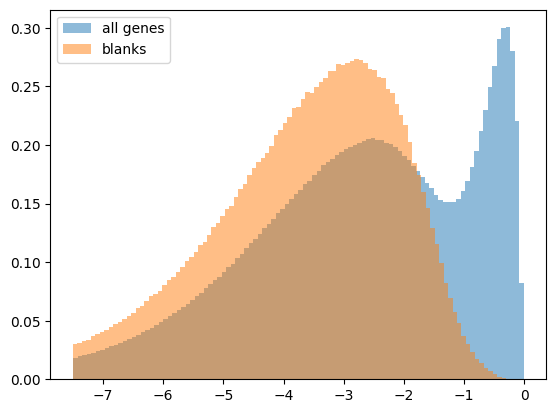

In [8]:
get_score(dec)

scores_ref_fl = save_folder+os.sep+'scores_BRBB.npy'
if not os.path.exists(scores_ref_fl):
    score_ref = np.sort(dec.score,axis=0)
    dec.score_ref = score_ref
    np.save(scores_ref_fl,score_ref)
else:
    dec.score_ref = np.load(scores_ref_fl)
    
set_scoreA(dec)
scoreA = dec.scoreA



bad_inds = [ign for ign,gn in enumerate(dec.gns_names) if 'blank' in gn]
is_bad = np.in1d(dec.icodesN,bad_inds)
is_good_gn = ~is_bad
th_min=-7.5
plt.figure()
kp = scoreA>th_min
plt.hist(scoreA[(is_good_gn)&kp],density=True,bins=100,alpha=0.5,label='all genes')
plt.hist(scoreA[(~is_good_gn)&kp],density=True,bins=100,alpha=0.5,label='blanks');
plt.legend()

[np.str_('Nfix'), np.str_('Ccnd2'), np.str_('Slc1a3'), np.str_('Pou3f3'), np.str_('Nfib'), np.str_('Slc17a7'), np.str_('Igfbpl1'), np.str_('Zeb2'), np.str_('Fxyd6'), np.str_('Sp9'), np.str_('Sp8'), np.str_('Dscaml1'), np.str_('Spon1'), np.str_('Sox2'), np.str_('Grik3'), np.str_('Bcl11a'), np.str_('Lrp4'), np.str_('Gad2'), np.str_('Gja1'), np.str_('Gfap'), np.str_('Vcan'), np.str_('Tnc'), np.str_('Slc38a1'), np.str_('Lhx2'), np.str_('Bcl11b'), np.str_('Sulf2'), np.str_('Tox3'), np.str_('Slc32a1'), np.str_('Fbln2'), np.str_('Mpped2')]


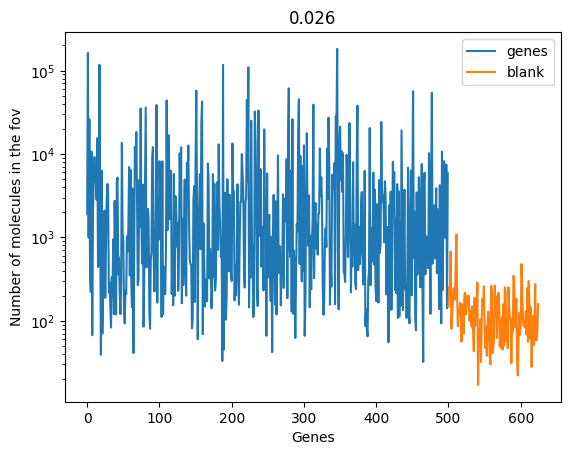

In [9]:
dec.th=-1.
dec.gns_names = np.array(dec.gns_names)
plot_statistics(dec)

In [10]:
def plot_multigenes(self,genes=['Gad1','Sox9'],colors=['r','g','b','m','c','y','w'],smin=3,smax=10,viewer = None,
                    drift=[0,0,0],resc=[1,1,1]):
    icodesN,XH_pruned = self.icodesN,self.XH_pruned
    scoreA=self.scoreA
    th=self.th
    gns_names = list(self.gns_names)
    
    Xcms = np.nanmean(XH_pruned,axis=1)
    keep = scoreA>th
    X = (Xcms[:,:3][keep]-drift)/resc  
    H = scoreA[keep]
    H -= np.min(H)
    icodesf = icodesN[keep]
    size = smin+np.clip(H/np.max(H),0,1)*(smax-smin)
    
    if viewer is None:
        import napari
        viewer = napari.Viewer()
    for igene,gene in enumerate(genes):
        color= colors[igene%len(colors)]
        icode = gns_names.index(gene)
        is_code = icode==icodesf
        viewer.add_points(X[is_code][:,1:],size=size[is_code],face_color=color,name=gene,border_width=0)
        #viewer.layers[-1].visible=False
    return viewer

In [14]:
plot_multigenes(dec,genes=['Slc17a7',
                           'Pou3f3','Gja1', 'Slc1a3','Gad2','Lamp5','Megf11','Igfbpl1'])

Viewer(camera=Camera(center=(0.0, np.float64(1394.0557733476162), np.float64(1407.0756831169128)), zoom=np.float64(0.2036999141118417), angles=(0.0, 0.0, 90.0), perspective=0.0, mouse_pan=True, mouse_zoom=True), cursor=Cursor(position=(1.0, 1.0), scaled=True, style=<CursorStyle.STANDARD: 'standard'>, size=1.0), dims=Dims(ndim=2, ndisplay=2, order=(0, 1), axis_labels=('0', '1'), rollable=(True, True), range=(RangeTuple(start=np.float64(-6.573551177978516), stop=np.float64(2792.916748046875), step=np.float64(1.0)), RangeTuple(start=np.float64(5.256903171539307), stop=np.float64(2813.3809407552085), step=np.float64(1.0))), margin_left=(0.0, 0.0), margin_right=(0.0, 0.0), point=(np.float64(1393.4264488220215), np.float64(1407.2569031715393)), last_used=0), grid=GridCanvas(stride=1, shape=(-1, -1), enabled=False), layers=[<Points layer 'Slc17a7' at 0x17551964fa0>, <Points layer 'Pou3f3' at 0x17551f327c0>, <Points layer 'Gja1' at 0x1755efbcfd0>, <Points layer 'Slc1a3' at 0x17564cdd910>, <Poi

Cannot find steve
